## Predicting Stocks Markets with PyTorch + Lightning

### Importing Libraries

In [ ]:
pip install lightning

In [ ]:
pip install yfinance

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam #similar to SGD but no so stochastic
import yfinance as yf
import pandas as pd
import numpy as np


In [ ]:
import lightning as L
from torch.utils.data import TensorDataset, DataLoader

### Defining our Class - LSTM

In [ ]:
class LSTM_lightning_personal(L.LightningModule):
  def __init__(self):
    super().__init__()
    # Taking a normal distribution
    mean = torch.tensor(0.0)
    std = torch.tensor(1.0)

    #long term gate
    self.wlr1 = nn.Parameter(torch.normal(mean=mean, std=std), requires_grad=True) #weight
    self.wlr2 = nn.Parameter(torch.normal(mean=mean, std=std), requires_grad=True)
    self.blr1 = nn.Parameter(torch.tensor(0.), requires_grad=True)      #bias

    #potential memory to remember gate
    self.wpr1 = nn.Parameter(torch.normal(mean=mean, std=std), requires_grad=True)
    self.wpr2 = nn.Parameter(torch.normal(mean=mean, std=std), requires_grad=True)
    self.bpr1 = nn.Parameter(torch.tensor(0.), requires_grad=True)

    #potential memory long term gate
    self.wp1 = nn.Parameter(torch.normal(mean=mean, std=std), requires_grad=True)
    self.wp2 = nn.Parameter(torch.normal(mean=mean, std=std), requires_grad=True)
    self.bp1 = nn.Parameter(torch.tensor(0.), requires_grad=True)

    #output
    self.wo1 = nn.Parameter(torch.normal(mean=mean, std=std), requires_grad=True)
    self.wo2 = nn.Parameter(torch.normal(mean=mean, std=std), requires_grad=True)


  def lstm_unit(self, input_value, long_memory, short_memory):

    long_remember_percent = torch.sigmoid((short_memory * self.wlr1) +
                                          (input_value * self.wlr2) +
                                          self.blr1)

    potential_remember_percent = torch.sigmoid((short_memory * self.wpr1) +
                                          (input_value * self.wpr2) +
                                          self.bpr1)

    potential_memory = torch.tanh((short_memory * self.wp1) +
                                          (input_value * self.wp2) +
                                          self.bp1)

    updated_long_memory = ((long_memory * long_remember_percent) +
                           (potential_remember_percent * potential_memory))

    output_percent = torch.sigmoid((short_memory * self.wo1) +
                                          (input_value * self.wo2))
    updated_short_memory = torch.tanh(updated_long_memory) * output_percent

    return ([updated_long_memory, updated_short_memory])



  def forward(self, input_seq):
        # Inicializa las memorias a cero en el primer paso
        long_memory = 0
        short_memory = 0

        # Itera a lo largo de todos los días de input_seq
        for day in range(input_seq.size(0)):
            # Obtén el dato para el día actual del conjunto de datos
            day_data = input_seq[day]

            # Pasa el dato del día actual a través de la LSTM
            long_memory, short_memory = self.lstm_unit(day_data, long_memory, short_memory)

        # Puedes hacer más cosas con las memorias aquí o retornarlas
        return long_memory, short_memory

  def configure_optimizers(self):
        # Define y configura tu optimizador aquí
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer

  def training_step(self, batch, batch_idx):
      # Obtener los datos de entrada y etiquetas del lote
      input_i, label_i = batch

      # Calcular la salida de la red (puede ser una tupla si es una LSTM)
      output_i = self.forward(input_i[0])

      # Si la salida es una tupla (salida a largo y corto plazo)
      if isinstance(output_i, tuple):
          output_i_long, output_i_short = output_i
      else:
          # Si no es una tupla, asumimos que es solo la salida a corto plazo
          output_i_long, output_i_short = output_i, output_i

      # Calcular la pérdida
      loss = ((output_i_short - label_i)**2).mean()

      # Registrar la pérdida en los registros de Lightning
      self.log("train_loss", loss)

      return loss



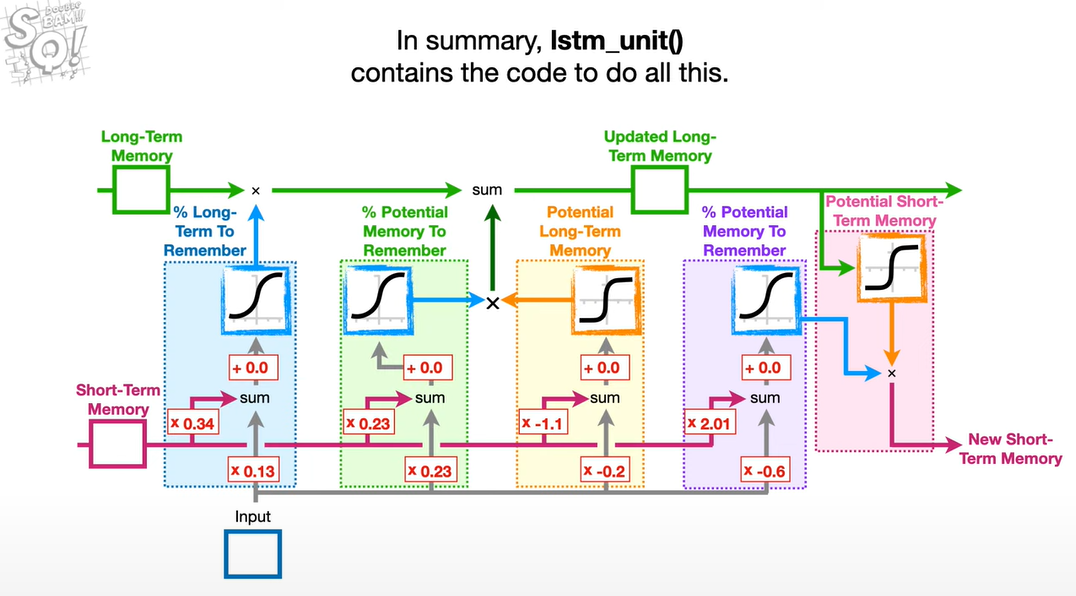

### LSTM Model

In [ ]:
model = LSTM_lightning_personal()

In [ ]:
model(torch.tensor([0., 0.5, 0.25, 1.]).detach())

(tensor(0.4366, grad_fn=<AddBackward0>),
 tensor(0.1552, grad_fn=<MulBackward0>))

In [ ]:
type(torch.tensor([0., 0.5, 0.25, -1.]))

torch.Tensor

In [ ]:
inputs = torch.tensor([[0., 0.5, 0.25, 1.], [1.,0.5,0.25,1.]])

In [ ]:
labels = torch.tensor([0., 1.])

In [ ]:
dataset = TensorDataset(inputs, labels)

In [ ]:
dataloader = DataLoader(dataset)


DataLoader is very useful:
* make it easy to access the data in batches
* make it easy to shuffle the data
* make it easy to use a small fraction of data (training or debbuging)

#### Training model

In [ ]:
trainer = L.Trainer(max_epochs=2000)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model, train_dataloaders=dataloader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name | Type | Params
------------------------------
------------------------------
11        Trainable params
0         Non-trainable params
11        Total params
0.000     Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name | Type | Params
------------------------------
------------------------------
11        Trainable params
0         Non-trainable params
11        Total params
0.000     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=1000` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1000` reached.


In [ ]:
#since we want to add additional training epochs to where we left off, we first get the path to the most recent checkpoints from the Lightning Trainer (we called it Trainer)

best_checkpoint = trainer.checkpoint_callback.best_model_path

In [ ]:
trainer = L.Trainer(max_epochs=4000)
trainer.fit(model, train_dataloaders=dataloader, ckpt_path=best_checkpoint)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/lightning_logs/version_1/checkpoints/epoch=999-step=2000.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/lightning_logs/version_1/checkpoints/epoch=999-step=2000.ckpt
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:337: UserWarning: The dirpath has changed from '/content/lightning_logs/version_1/checkpoints' to '/content/lightning_logs/version_

Training: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=4000` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=4000` reached.


#### Prediction

In [ ]:
model(torch.tensor([0., 0.5, 0.25, 1.]).detach()) #label is 0

(tensor(1.4901e-05, grad_fn=<AddBackward0>),
 tensor(1.2915e-05, grad_fn=<MulBackward0>))

In [ ]:
model(torch.tensor([1.,0.5,0.25,1.]).detach()) #label is 1


(tensor(3.6126, grad_fn=<AddBackward0>),
 tensor(0.9911, grad_fn=<MulBackward0>))

In [ ]:
best_checkpoint = trainer.checkpoint_callback.best_model_path

In [ ]:
import torch.nn as nn
input_size = 1 #len(data.columns)
hidden_size = 1  # El tamaño oculto de la capa LSTM
num_layers = 2  # Número de capas LSTM

### LSTM w/ nn

In [ ]:
class LightningLSTM(L.LightningModule):
  def __init__(self):
    super().__init__()
    self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size)


  def forward(self, input):
    input_transposed = input.view(len(input), 1)  #rows = len(input), columns = 1
    lstm_out, temp = self.lstm(input_transposed)

    prediction = lstm_out[-1]
    return prediction

  def configure_optimizers(self):
    return Adam(self.parameters(), lr=0.1)

  def training_step(self, batch, batch_idx):
    input_i, label_i = batch
    output_i = self.forward(input_i[0])
    loss = (output_i - label_i) ** 2

    self.log("train loss: ", loss)

    if (label_i == 0):
      self.log("out_0: ", output_i)
    else:
      self.log("out_1: ", output_i)
    return loss

#### Training Model 2

In [ ]:
trainer = L.Trainer(max_epochs=300, log_every_n_steps=2)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
model2 = LightningLSTM()

In [ ]:
trainer.fit(model2, train_dataloaders=dataloader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name | Type | Params
------------------------------
0 | lstm | LSTM | 16    
------------------------------
16        Trainable params
0         Non-trainable params
16        Total params
0.000     Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name | Type | Params
------------------------------
0 | lstm | LSTM | 16    
------------------------------
16        Trainable params
0         Non-trainable params
16        Total params
0.000     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=300` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=300` reached.


#### Predictions - Model 2

In [ ]:
model2(torch.tensor([0., 0.5, 0.25, 1.]).detach()) #label is 0

tensor([8.8940e-06], grad_fn=<SelectBackward0>)

In [ ]:
model2(torch.tensor([1.,0.5,0.25,1.]).detach()) #label is 1


tensor([0.9872], grad_fn=<SelectBackward0>)

### *Testing* with real data


In [ ]:
from datetime import datetime

start_date = '2020-05-25'
end_date = datetime.today().strftime('%Y-%m-%d')

apple_data = yf.download("AAPL", start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


In [ ]:
apple_data = apple_data.dropna()

In [ ]:
apple_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-05-26,80.875000,81.059998,79.125000,79.182503,77.636673,125522000
2020-05-27,79.035004,79.677498,78.272499,79.527496,77.974937,112945200
2020-05-28,79.192497,80.860001,78.907501,79.562500,78.009254,133560800
2020-05-29,79.812500,80.287498,79.117500,79.485001,77.933266,153532400
2020-06-01,79.437500,80.587502,79.302498,80.462502,78.891678,80791200
...,...,...,...,...,...,...
2023-09-29,172.020004,173.070007,170.339996,171.210007,171.210007,51814200
2023-10-02,171.220001,174.300003,170.929993,173.750000,173.750000,52164500
2023-10-03,172.259995,173.630005,170.820007,172.399994,172.399994,49594600


In [ ]:
apple_data.shape

(848, 6)

In [ ]:
import torch.nn as nn
input_size = 1 #len(data.columns)
hidden_size = 1  # El tamaño oculto de la capa LSTM
num_layers = 2  # Número de capas LSTM

In [ ]:
class LightningLSTM_2(L.LightningModule):
  def __init__(self):
    super().__init__()
    self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size)


  def forward(self, input):
    #input_transposed = input.view(len(input), 1)  #rows = len(input), columns = 1
    lstm_out, temp = self.lstm(input)

    prediction = lstm_out[-1]
    return prediction

  def configure_optimizers(self):
    return Adam(self.parameters(), lr=0.1)

  def training_step(self, batch, batch_idx):
    input_i, label_i = batch
    output_i = self.forward(input_i[0])
    loss = (output_i - label_i) ** 2

    self.log("train loss: ", loss)

    if (label_i == 0):
      self.log("out_0: ", output_i)
    else:
      self.log("out_1: ", output_i)
    return loss

  def predict_next_days(self, input_sequence, days):
        # Initialize a list to store the predictions
        predictions = []

        # Iterate for the next 30 days
        for _ in range(days):
            # Feed the input_sequence to the model
            output = self.forward(input_sequence)
            #output = output[:, :, :1]

            # Append the prediction to the list
            predictions.append(output)

            # Update the input_sequence for the next iteration
            input_sequence = torch.cat((input_sequence[1:], output.view(1, 1, -1)), dim=0)

        return torch.cat(predictions, dim=0)




In [ ]:
apple_data_new = apple_data[::-1].reset_index(drop=False)
apple_data_new

,Date,Open,High,Low,Close,Adj Close,Volume
0,2023-10-05,173.789993,175.449997,172.679993,174.910004,174.910004,48494400
1,2023-10-04,171.089996,174.210007,170.970001,173.660004,173.660004,53020300
2,2023-10-03,172.259995,173.630005,170.820007,172.399994,172.399994,49594600
3,2023-10-02,171.220001,174.300003,170.929993,173.750000,173.750000,52164500
4,2023-09-29,172.020004,173.070007,170.339996,171.210007,171.210007,51814200
...,...,...,...,...,...,...,...
843,2020-06-01,79.437500,80.587502,79.302498,80.462502,78.891678,80791200
844,2020-05-29,79.812500,80.287498,79.117500,79.485001,77.933266,153532400
845,2020-05-28,79.192497,80.860001,78.907501,79.562500,78.009254,133560800
846,2020-05-27,79.035004,79.677498,78.272499,79.527496,77.974937,112945200


In [ ]:
apple_data_new["Open"].dtypes

dtype('float64')

In [ ]:
data_array = apple_data_new.values[:,1:-1]
data_array = data_array.astype(np.float32)

In [ ]:
data_array

array([[173.79    , 175.45    , 172.68    , 174.91    , 174.91    ],
       [171.09    , 174.21    , 170.97    , 173.66    , 173.66    ],
       [172.26    , 173.63    , 170.82    , 172.4     , 172.4     ],
       ...,
       [ 79.1925  ,  80.86    ,  78.9075  ,  79.5625  ,  78.009254],
       [ 79.035   ,  79.6775  ,  78.2725  ,  79.5275  ,  77.97494 ],
       [ 80.875   ,  81.06    ,  79.125   ,  79.1825  ,  77.63667 ]],
      dtype=float32)

In [ ]:
data_tensor = torch.tensor(data_array, dtype=torch.float32)


In [ ]:
data_tensor.shape

torch.Size([848, 5])

In [ ]:
input_sequences_tensor.shape

torch.Size([819, 30, 5])

In [ ]:
output.shape

torch.Size([1, 1, 30])